Dimensions: 100%|██████████| 1/1 [00:48<00:00, 48.34s/it]


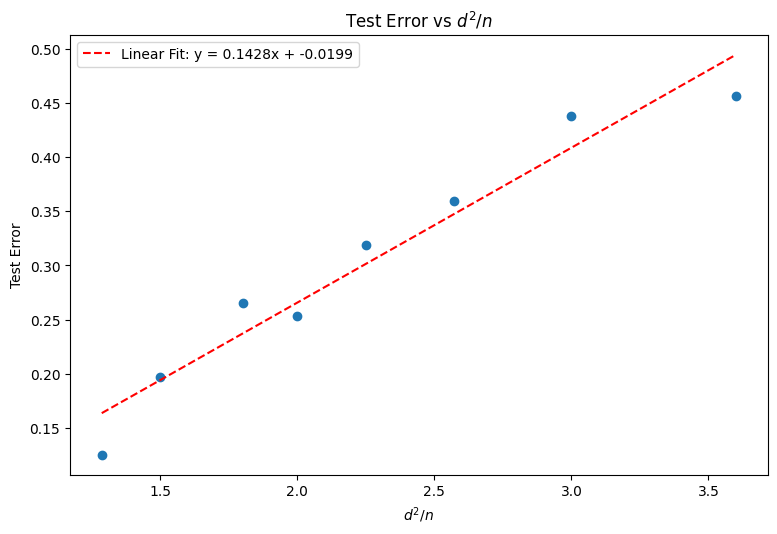

Experimental Results:
 d |   n  | d²/n  | Test Error
--|------|-------|------------
6 |   10 |  3.60 | 0.4562
6 |   12 |  3.00 | 0.4375
6 |   14 |  2.57 | 0.3594
6 |   16 |  2.25 | 0.3187
6 |   18 |  2.00 | 0.2531
6 |   20 |  1.80 | 0.2656
6 |   24 |  1.50 | 0.1969
6 |   28 |  1.29 | 0.1250

Proportionality constant estimate: 0.1428


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 生成完整的2-XOR数据集
def generate_2xor_dataset(d):
    """生成完整的2-XOR数据集 (2^d个点)"""
    # 前两个坐标的四种组合
    base_points = [
        (1/np.sqrt(d-1), 0, 1),   # (x1, x2, y)
        (0, 1/np.sqrt(d-1), -1),
        (-1/np.sqrt(d-1), 0, 1),
        (0, -1/np.sqrt(d-1), -1)
    ]

    # 后d-2个坐标的可能取值
    coord_values = [-1/np.sqrt(d-1), 1/np.sqrt(d-1)]
    extra_combinations = list(product(coord_values, repeat=d-2))

    # 构建完整数据集
    X = []
    y = []

    for base in base_points:
        for extra in extra_combinations:
            # 前两个坐标 + 后d-2个坐标
            x_vec = [base[0], base[1]] + list(extra)
            X.append(x_vec)
            y.append(base[2])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 从完整数据集中采样
def sample_dataset(X_full, y_full, n):
    """从完整数据集中采样n个点"""
    indices = torch.randperm(len(X_full))[:n]
    return X_full[indices], y_full[indices]

# ReLU网络模型
class ReLUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# 训练函数 (使用GD)
def train_model(X_train, y_train, epochs=2000, lr=0.1, tol=1e-6):
    d = X_train.shape[1]
    model = ReLUNet(d)
    criterion = nn.BCEWithLogitsLoss()  # logistic loss
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # 转换标签为0/1
    y_train_bce = (y_train + 1) / 2

    prev_loss = float('inf')
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train_bce)
        loss.backward()
        optimizer.step()

        # 检查收敛
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()

    return model

# 评估函数
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        predictions = (outputs > 0).float()
        accuracy = (predictions == ((y_test + 1) / 2)).float().mean()
        return 1 - accuracy.item()

# 主实验函数
def run_experiment(d_values, n_values, n_trials=5):
    """运行实验并返回结果"""
    results = []

    for d in tqdm(d_values, desc="Dimensions"):
        # 生成完整数据集 (2^d个点)
        X_full, y_full = generate_2xor_dataset(d)

        for n in n_values:
            # 确保n不超过数据集大小
            max_n = len(X_full)
            actual_n = min(n, max_n)

            # 多次重复实验
            errors = []
            for _ in range(n_trials):
                # 采样训练集
                X_train, y_train = sample_dataset(X_full, y_full, actual_n)

                # 使用完整数据集作为测试集
                X_test, y_test = X_full, y_full

                # 训练模型
                model = train_model(X_train, y_train)

                # 评估模型
                error = evaluate_model(model, X_test, y_test)
                errors.append(error)

            # 记录结果
            avg_error = np.mean(errors)
            results.append({
                'd': d,
                'n': actual_n,
                'd_sq_over_n': d**2 / actual_n,
                'test_error': avg_error
            })

    return results

# 实验参数设置
d_values = [6]  # 维度d (d≥3)
n_values = [10,12,14,16,18,20,24,28]  # 样本量n

# 运行实验
experiment_results = run_experiment(d_values, n_values, n_trials=5)

# 分析并可视化结果
def analyze_results(results):
    # 提取数据
    d_sq_over_n = [r['d_sq_over_n'] for r in results]
    test_errors = [r['test_error'] for r in results]

    # 创建图表
    plt.figure(figsize=(15, 10))

    # 图1: Test error vs d²/n
    plt.subplot(2, 2, 1)
    plt.scatter(d_sq_over_n, test_errors)
    plt.xlabel('$d^2/n$')
    plt.ylabel('Test Error')
    plt.title('Test Error vs $d^2/n$')

    # 添加趋势线
    coeffs = np.polyfit(d_sq_over_n, test_errors, 1)
    trend_line = np.poly1d(coeffs)
    x_vals = np.linspace(min(d_sq_over_n), max(d_sq_over_n), 100)
    plt.plot(x_vals, trend_line(x_vals), 'r--',
             label=f'Linear Fit: y = {coeffs[0]:.4f}x + {coeffs[1]:.4f}')
    plt.legend()




    plt.tight_layout()
    plt.show()

    # 打印结果
    print("Experimental Results:")
    print(" d |   n  | d²/n  | Test Error")
    print("--|------|-------|------------")
    for r in results:
        print(f"{r['d']} | {r['n']:4} | {r['d_sq_over_n']:5.2f} | {r['test_error']:.4f}")

    return slope, coeffs[0]

# 分析结果
slope, prop_const = analyze_results(experiment_results)
print(f"\nProportionality constant estimate: {prop_const:.4f}")


Dimensions: 100%|██████████| 10/10 [00:34<00:00,  3.43s/it]


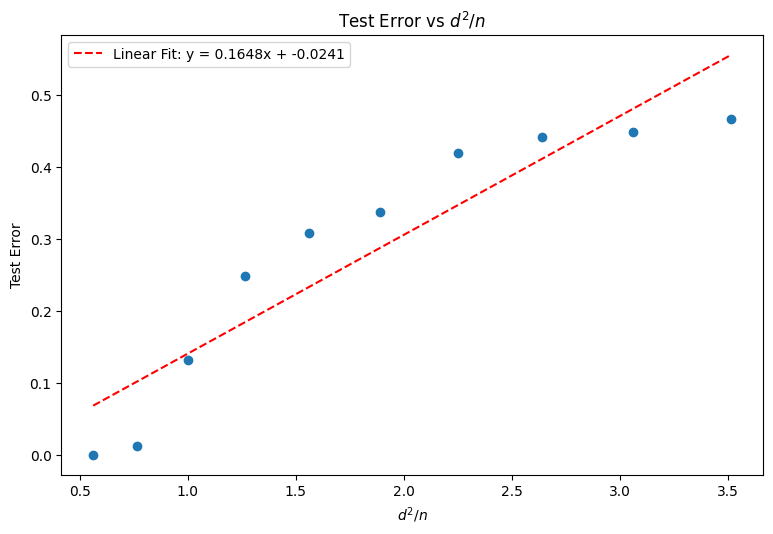

Experimental Results:
 d |   n  | d²/n  | Test Error
--|------|-------|------------
6 |   64 |  0.56 | 0.0000
7 |   64 |  0.77 | 0.0125
8 |   64 |  1.00 | 0.1313
9 |   64 |  1.27 | 0.2484
10 |   64 |  1.56 | 0.3080
11 |   64 |  1.89 | 0.3365
12 |   64 |  2.25 | 0.4190
13 |   64 |  2.64 | 0.4406
14 |   64 |  3.06 | 0.4479
15 |   64 |  3.52 | 0.4654

Proportionality constant estimate: 0.1648


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 生成完整的2-XOR数据集
def generate_2xor_dataset(d):
    """生成完整的2-XOR数据集 (2^d个点)"""
    # 前两个坐标的四种组合
    base_points = [
        (1/np.sqrt(d-1), 0, 1),   # (x1, x2, y)
        (0, 1/np.sqrt(d-1), -1),
        (-1/np.sqrt(d-1), 0, 1),
        (0, -1/np.sqrt(d-1), -1)
    ]

    # 后d-2个坐标的可能取值
    coord_values = [-1/np.sqrt(d-1), 1/np.sqrt(d-1)]
    extra_combinations = list(product(coord_values, repeat=d-2))

    # 构建完整数据集
    X = []
    y = []

    for base in base_points:
        for extra in extra_combinations:
            # 前两个坐标 + 后d-2个坐标
            x_vec = [base[0], base[1]] + list(extra)
            X.append(x_vec)
            y.append(base[2])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 从完整数据集中采样
def sample_dataset(X_full, y_full, n):
    """从完整数据集中采样n个点"""
    indices = torch.randperm(len(X_full))[:n]
    return X_full[indices], y_full[indices]

# ReLU网络模型
class ReLUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ReLUNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

# 训练函数 (使用GD)
def train_model(X_train, y_train, epochs=1000, lr=0.1, tol=1e-6):
    d = X_train.shape[1]
    model = ReLUNet(d)
    criterion = nn.BCEWithLogitsLoss()  # logistic loss
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # 转换标签为0/1
    y_train_bce = (y_train + 1) / 2

    prev_loss = float('inf')
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train_bce)
        loss.backward()
        optimizer.step()

        # 检查收敛
        if abs(prev_loss - loss.item()) < tol:
            break
        prev_loss = loss.item()

    return model

# 评估函数
def evaluate_model(model, X_test, y_test):
    with torch.no_grad():
        outputs = model(X_test)
        predictions = (outputs > 0).float()
        accuracy = (predictions == ((y_test + 1) / 2)).float().mean()
        return 1 - accuracy.item()

# 主实验函数
def run_experiment(d_values, n_values, n_trials=5):
    """运行实验并返回结果"""
    results = []

    for d in tqdm(d_values, desc="Dimensions"):
        # 生成完整数据集 (2^d个点)
        X_full, y_full = generate_2xor_dataset(d)

        for n in n_values:
            # 确保n不超过数据集大小
            max_n = len(X_full)
            actual_n = min(n, max_n)

            # 多次重复实验
            errors = []
            for _ in range(n_trials):
                # 采样训练集
                X_train, y_train = sample_dataset(X_full, y_full, actual_n)

                # 使用完整数据集作为测试集
                X_test, y_test = X_full, y_full

                # 训练模型
                model = train_model(X_train, y_train)

                # 评估模型
                error = evaluate_model(model, X_test, y_test)
                errors.append(error)

            # 记录结果
            avg_error = np.mean(errors)
            results.append({
                'd': d,
                'n': actual_n,
                'd_sq_over_n': d**2 / actual_n,
                'test_error': avg_error
            })

    return results

# 实验参数设置
d_values = [6,7,8,9,10,11,12,13,14,15]  # 维度d (d≥3)
n_values = [64]  # 样本量n

# 运行实验
experiment_results = run_experiment(d_values, n_values, n_trials=5)

# 分析并可视化结果
def analyze_results(results):
    # 提取数据
    d_sq_over_n = [r['d_sq_over_n'] for r in results]
    test_errors = [r['test_error'] for r in results]

    # 创建图表
    plt.figure(figsize=(15, 10))

    # 图1: Test error vs d²/n
    plt.subplot(2, 2, 1)
    plt.scatter(d_sq_over_n, test_errors)
    plt.xlabel('$d^2/n$')
    plt.ylabel('Test Error')
    plt.title('Test Error vs $d^2/n$')

    # 添加趋势线
    coeffs = np.polyfit(d_sq_over_n, test_errors, 1)
    trend_line = np.poly1d(coeffs)
    x_vals = np.linspace(min(d_sq_over_n), max(d_sq_over_n), 100)
    plt.plot(x_vals, trend_line(x_vals), 'r--',
             label=f'Linear Fit: y = {coeffs[0]:.4f}x + {coeffs[1]:.4f}')
    plt.legend()



    plt.tight_layout()
    plt.show()

    # 打印结果
    print("Experimental Results:")
    print(" d |   n  | d²/n  | Test Error")
    print("--|------|-------|------------")
    for r in results:
        print(f"{r['d']} | {r['n']:4} | {r['d_sq_over_n']:5.2f} | {r['test_error']:.4f}")

    return slope, coeffs[0]

# 分析结果
slope, prop_const = analyze_results(experiment_results)
print(f"\nProportionality constant estimate: {prop_const:.4f}")